# Pedestrian Crash Analysis

# Import Modules

In [1]:
import logging
from pathlib import Path
from application import App
from dataset_reader import DatasetFromFiles, DatasetReaderCSV
from pathlib import Path
from dataset_preprocessor import DatasetPreprocessor
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import plot_model
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Export simulation datasets from csv

## Without timeseries

In [2]:
ch = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s', "%H:%M:%S")
ch.setFormatter(formatter)

path = Path("C:\\Users\geork\projects\AIThesis\datasets\\20240510\mlres")
out_path = Path("C:\\Users\geork\projects\AIThesis\src\\datasets\\crash_simulation_no_timeseries.csv")
r = DatasetFromFiles(path)
r.setOutputPath(out_path, True)

app = App()
app.setLogger(ch)
app.setReader(r)
app.run()

10:46:32 - INFO - Reader configured
10:46:32 - INFO - Reading dataset from directory: C:\Users\geork\projects\AIThesis\datasets\20240510\mlres
10:46:32 - INFO - Total number of simulation cases: 1200
Parsing simulation files: 100%|██████████| 1200/1200 [01:26<00:00, 13.81item/s]
10:47:59 - INFO - Finished... Results writtern in C:\Users\geork\projects\AIThesis\src\datasets\crash_simulation_no_timeseries.csv


## With timeseries

In [3]:
ch = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s', "%H:%M:%S")
ch.setFormatter(formatter)

path = Path("C:\\Users\geork\projects\AIThesis\datasets\\20240510\mlres")
out_path = Path("C:\\Users\geork\projects\AIThesis\src\\datasets\\crash_simulation_timeseries.csv")
r = DatasetFromFiles(path)
r.setTimeSeriesLabel("Head_X_Coordinate")
r.setTimeSeriesLabel("Head_Y_Coordinate")
r.setTimeSeriesLabel("Head_Z_Coordinate")
r.setTimeSeriesLabel("Sternum_X_Coordinate")
r.setTimeSeriesLabel("Sternum_Y_Coordinate")
r.setTimeSeriesLabel("Sternum_Z_Coordinate")

r.setOutputPath(out_path, True)

app = App()
app.setLogger(ch)
app.setReader(r)
app.run()

10:47:59 - INFO - Dataset will include timeseries: Head_X_Coordinate
10:47:59 - INFO - Dataset will include timeseries: Head_Y_Coordinate
10:47:59 - INFO - Dataset will include timeseries: Head_Z_Coordinate
10:47:59 - INFO - Dataset will include timeseries: Sternum_X_Coordinate
10:47:59 - INFO - Dataset will include timeseries: Sternum_Y_Coordinate
10:47:59 - INFO - Dataset will include timeseries: Sternum_Z_Coordinate
10:47:59 - INFO - Reader configured
10:47:59 - INFO - Reader configured
10:47:59 - INFO - Reading dataset from directory: C:\Users\geork\projects\AIThesis\datasets\20240510\mlres
10:47:59 - INFO - Reading dataset from directory: C:\Users\geork\projects\AIThesis\datasets\20240510\mlres
10:48:00 - INFO - Total number of simulation cases: 1200
10:48:00 - INFO - Total number of simulation cases: 1200
Parsing simulation files: 100%|██████████| 1200/1200 [01:28<00:00, 13.63item/s]
10:49:31 - INFO - Finished... Results writtern in C:\Users\geork\projects\AIThesis\src\datasets\c

# Convert csv file to Dataframe

In [4]:
path = Path("C:\\Users\geork\projects\AIThesis\src\datasets\crash_simulation_no_timeseries.csv")
reader = DatasetReaderCSV(path)

preprocessor = DatasetPreprocessor()
preprocessor.setReader(reader)
reader.read()
df = reader.convert_to_dataframe()

# Dataset Analysis

In [5]:
# Count missing values in each column
print(">>>> NUMBER OF MISSING VALUES PER COLUMN <<<<")
missing_values_count = df.isnull().sum()
print(missing_values_count)

>>>> NUMBER OF MISSING VALUES PER COLUMN <<<<
Unnamed: 0                                  0
Path                                        0
CarProfile                                  0
Velocity                                    0
Translation                                 0
Rotation                                    0
Position                                    0
HIC15_max                                   0
HIC36_max                                   0
Head_Z_Acceleration_abs_max                 0
Head_X_Acceleration_abs_max                 0
Head_Y_Acceleration_abs_max                 0
BrIC_abs_max                                0
Chest_Resultant_Acceleration_max            0
Chest_Resultant_Acceleration_CLIP3ms_max    0
dtype: int64


## Dataset Overview

In [6]:
# Exclude the 'Position' column from the DataFrame
df_excluded = df.drop(columns=['Position'], errors='ignore')

# Create a scrollable HTML table
scrollable_table_html = f"""
<style>
    .scrollable-table {{
        height: 400px;
        overflow-y: auto;
        border: 1px solid #ddd;
        padding: 10px;
    }}
    .scrollable-table table {{
        border-collapse: collapse;
        width: 100%;
    }}
    .scrollable-table th, .scrollable-table td {{
        border: 1px solid lightgray;
        padding: 8px;
        text-align: left;
    }}
    .scrollable-table th {{
        position: -webkit-sticky;
        position: sticky;
        top: 0;
        background: gray;
        color: white;
        z-index: 10;
    }}
</style>
<div class="scrollable-table">
  {df_excluded.to_html(index=False)}
</div>
"""

display(HTML(scrollable_table_html))



Unnamed: 0,Path,CarProfile,Velocity,Translation,Rotation,HIC15_max,HIC36_max,Head_Z_Acceleration_abs_max,Head_X_Acceleration_abs_max,Head_Y_Acceleration_abs_max,BrIC_abs_max,Chest_Resultant_Acceleration_max,Chest_Resultant_Acceleration_CLIP3ms_max
0,C:\Users\geork\projects\AIThesis\datasets\20240510\mlres\Type=FCR_Vel=100_tra=-200_rot=0_pos=initial.txt,FCR,100,-200,0,86.843,136.373,36.081,7.578,17.539,0.920,34.882,28.117
1,C:\Users\geork\projects\AIThesis\datasets\20240510\mlres\Type=FCR_Vel=100_tra=-200_rot=120_pos=initial.txt,FCR,100,-200,120,2361.697,2866.369,103.348,179.802,54.333,1.718,36.302,19.450
2,C:\Users\geork\projects\AIThesis\datasets\20240510\mlres\Type=FCR_Vel=100_tra=-200_rot=150_pos=initial.txt,FCR,100,-200,150,573.455,573.455,74.161,77.655,72.795,0.936,24.091,19.183
3,C:\Users\geork\projects\AIThesis\datasets\20240510\mlres\Type=FCR_Vel=100_tra=-200_rot=180_pos=initial.txt,FCR,100,-200,180,84.702,153.528,35.330,13.216,13.956,0.905,49.501,28.255
4,C:\Users\geork\projects\AIThesis\datasets\20240510\mlres\Type=FCR_Vel=100_tra=-200_rot=210_pos=initial.txt,FCR,100,-200,210,592.965,592.965,42.322,138.277,19.926,0.965,25.420,18.131
5,C:\Users\geork\projects\AIThesis\datasets\20240510\mlres\Type=FCR_Vel=100_tra=-200_rot=240_pos=initial.txt,FCR,100,-200,240,1235.194,1235.194,65.935,136.515,38.005,1.127,40.085,30.059
6,C:\Users\geork\projects\AIThesis\datasets\20240510\mlres\Type=FCR_Vel=100_tra=-200_rot=270_pos=initial.txt,FCR,100,-200,270,6257.955,6257.955,141.311,391.280,11.465,1.543,69.245,35.402
7,C:\Users\geork\projects\AIThesis\datasets\20240510\mlres\Type=FCR_Vel=100_tra=-200_rot=300_pos=initial.txt,FCR,100,-200,300,4974.677,4974.677,100.702,453.532,31.697,1.193,50.792,43.538
8,C:\Users\geork\projects\AIThesis\datasets\20240510\mlres\Type=FCR_Vel=100_tra=-200_rot=30_pos=initial.txt,FCR,100,-200,30,775.362,775.362,58.451,119.153,65.954,0.929,25.538,18.412
9,C:\Users\geork\projects\AIThesis\datasets\20240510\mlres\Type=FCR_Vel=100_tra=-200_rot=330_pos=initial.txt,FCR,100,-200,330,440.203,440.203,37.944,104.015,34.352,1.176,24.579,18.154


## Dataframe description

In [7]:
summary_stats = df.describe()
print(summary_stats)

        Unnamed: 0     Velocity  Translation     Rotation      HIC15_max  \
count  1200.000000  1200.000000  1200.000000  1200.000000    1200.000000   
mean    599.500000    60.000000     0.000000   165.000000   10594.607520   
std     346.554469    28.296064   282.960637   103.604754   28156.535615   
min       0.000000    20.000000  -400.000000     0.000000       0.000000   
25%     299.750000    40.000000  -200.000000    82.500000     444.451250   
50%     599.500000    60.000000     0.000000   165.000000    1826.896500   
75%     899.250000    80.000000   200.000000   247.500000    7791.743000   
max    1199.000000   100.000000   400.000000   330.000000  277304.682000   

           HIC36_max  Head_Z_Acceleration_abs_max  \
count    1200.000000                  1200.000000   
mean    10652.672504                   180.719489   
std     28139.017094                   282.624541   
min         0.000000                     0.000000   
25%       452.599750                    45.476000 

### Car Attributes: Profiles - Velocities

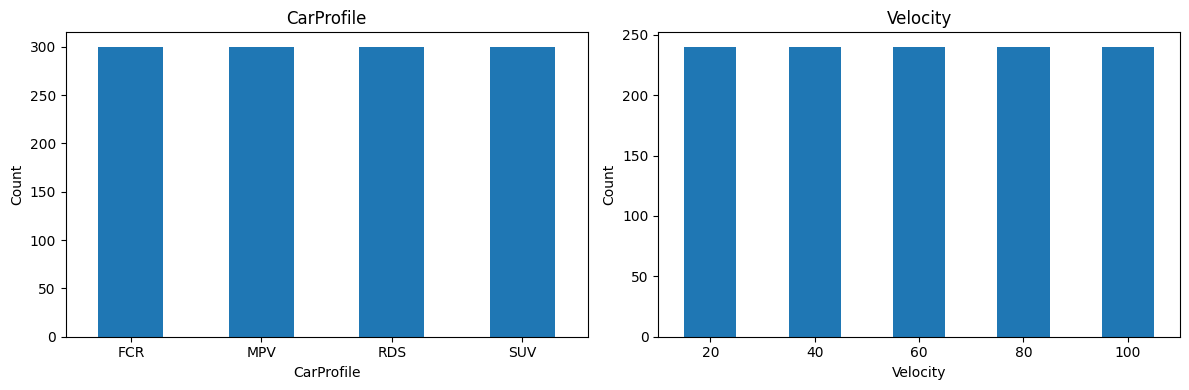

In [8]:
# Count the occurrences of each unique value in the 'Rotation' column and sort by label
counts_translation = df['CarProfile'].value_counts().sort_index()
counts_position = df["Velocity"].value_counts().sort_index()

# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot the first bar chart
counts_translation.plot(kind='bar', ax=ax1)
ax1.set_title('CarProfile')
ax1.set_xlabel('CarProfile')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=0)  # Rotate x labels for better readability

# Plot the second bar chart
counts_position.plot(kind='bar', ax=ax2)
ax2.set_title('Velocity')
ax2.set_xlabel('Velocity')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=0)  # Rotate x labels for better readability

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()

### Pedestration Attributes: Translation - Rotation

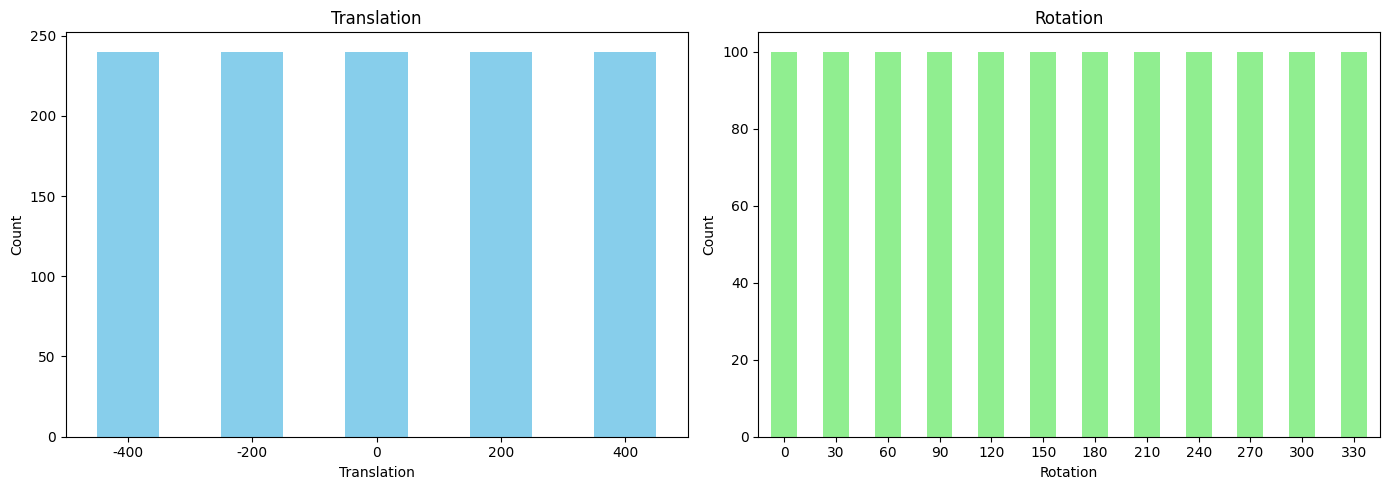

In [9]:
# Convert rotation labels to integers if they are not already
df['Translation'] = df['Translation'].astype(int)
df["Rotation"] = df["Rotation"].astype(int)
    
# Count the occurrences of each unique value in the 'Rotation' column and sort by label
counts_translation = df['Translation'].value_counts().sort_index()
counts_position = df["Rotation"].value_counts().sort_index()


# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot the first bar chart
counts_translation.plot(kind='bar', ax=ax1, color='skyblue')
ax1.set_title('Translation')
ax1.set_xlabel('Translation')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=0)  # Rotate x labels for better readability

# Plot the second bar chart
counts_position.plot(kind='bar', ax=ax2, color='lightgreen')
ax2.set_title('Rotation')
ax2.set_xlabel('Rotation')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=0)  # Rotate x labels for better readability

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()

### Possible target value: HIC15_max / HIC36_max

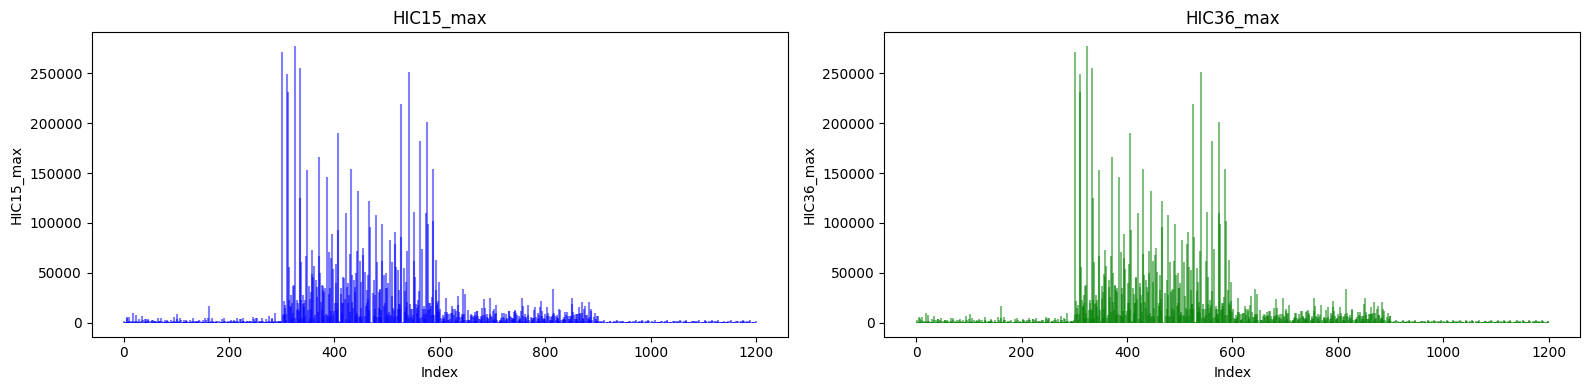

In [10]:
# Create a figure and axes for the subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

# Vertical lines plot for 'HIC15_max'
axes[0].vlines(df.index, ymin=0, ymax=df['HIC15_max'], color='blue', alpha=0.5)
axes[0].set_title('HIC15_max')
axes[0].set_xlabel('Index')
axes[0].set_ylabel('HIC15_max')

# Vertical lines plot for 'HIC36_max'
axes[1].vlines(df.index, ymin=0, ymax=df['HIC36_max'], color='green', alpha=0.5)
axes[1].set_title('HIC36_max')
axes[1].set_xlabel('Index')
axes[1].set_ylabel('HIC36_max')

# Adjust layout
plt.tight_layout()
plt.show()

### Head XYZ Acceleration

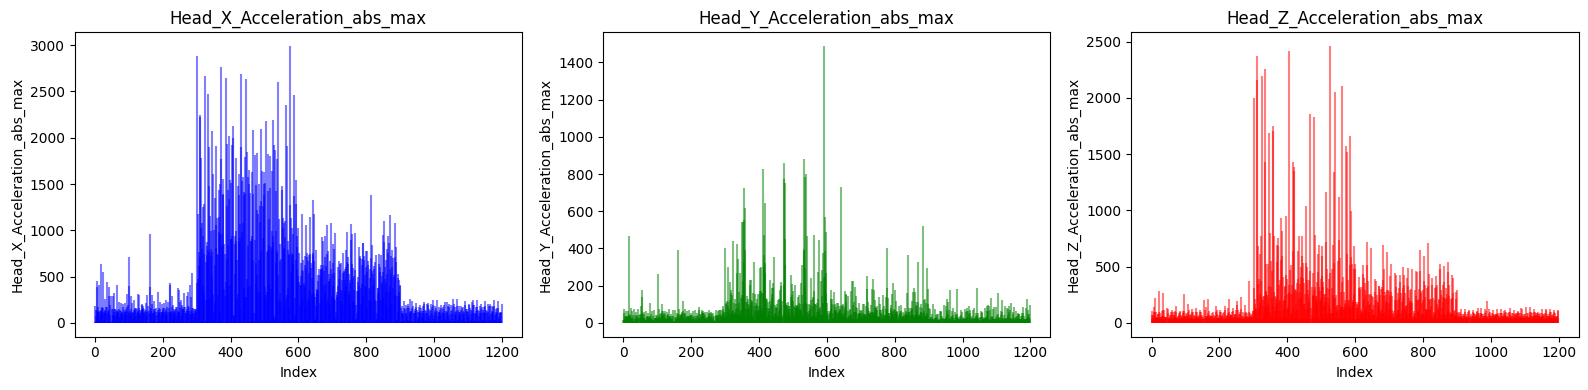

In [11]:
# Create a figure and axes for the subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

# Vertical lines plot for 'HIC15_max'
axes[0].vlines(df.index, ymin=0, ymax=df['Head_X_Acceleration_abs_max'], color='blue', alpha=0.5)
axes[0].set_title('Head_X_Acceleration_abs_max')
axes[0].set_xlabel('Index')
axes[0].set_ylabel('Head_X_Acceleration_abs_max')

# Vertical lines plot for 'HIC36_max'
axes[1].vlines(df.index, ymin=0, ymax=df['Head_Y_Acceleration_abs_max'], color='green', alpha=0.5)
axes[1].set_title('Head_Y_Acceleration_abs_max')
axes[1].set_xlabel('Index')
axes[1].set_ylabel('Head_Y_Acceleration_abs_max')

# Vertical lines plot for 'HIC36_max'
axes[2].vlines(df.index, ymin=0, ymax=df['Head_Z_Acceleration_abs_max'], color='red', alpha=0.5)
axes[2].set_title('Head_Z_Acceleration_abs_max')
axes[2].set_xlabel('Index')
axes[2].set_ylabel('Head_Z_Acceleration_abs_max')

# Adjust layout
plt.tight_layout()
plt.show()

### Brain Injury Damage(BrIC) - Chest_Resultant_Acceleration_max - Chest_Resultant_Acceleration_CLIP3ms_max

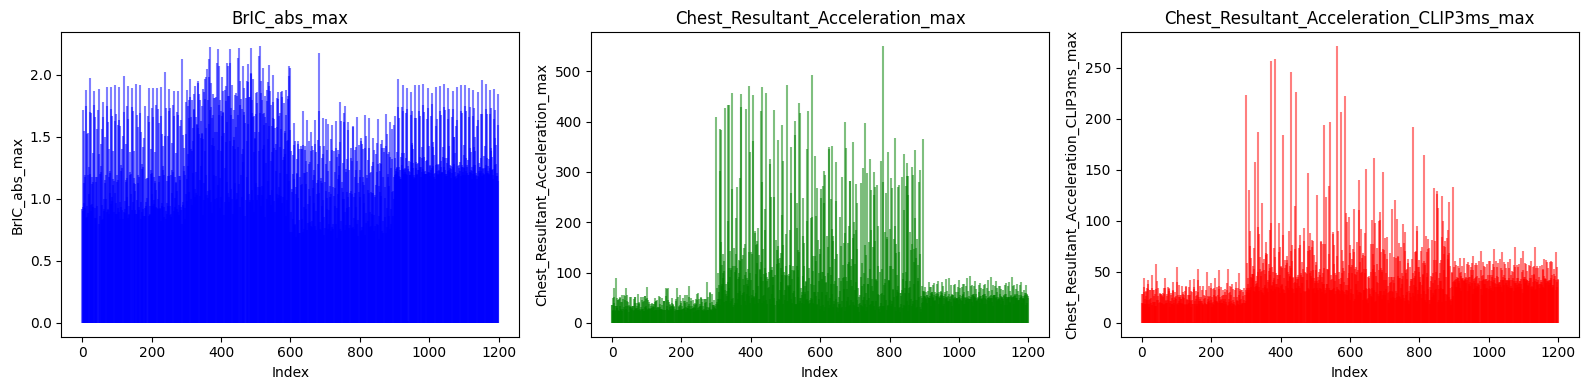

In [12]:
# Create a figure and axes for the subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

# Vertical lines plot for 'HIC15_max'
axes[0].vlines(df.index, ymin=0, ymax=df['BrIC_abs_max'], color='blue', alpha=0.5)
axes[0].set_title('BrIC_abs_max')
axes[0].set_xlabel('Index')
axes[0].set_ylabel('BrIC_abs_max')

# Vertical lines plot for 'HIC36_max'
axes[1].vlines(df.index, ymin=0, ymax=df['Chest_Resultant_Acceleration_max'], color='green', alpha=0.5)
axes[1].set_title('Chest_Resultant_Acceleration_max')
axes[1].set_xlabel('Index')
axes[1].set_ylabel('Chest_Resultant_Acceleration_max')

# Vertical lines plot for 'HIC36_max'
axes[2].vlines(df.index, ymin=0, ymax=df['Chest_Resultant_Acceleration_CLIP3ms_max'], color='red', alpha=0.5)
axes[2].set_title('Chest_Resultant_Acceleration_CLIP3ms_max')
axes[2].set_xlabel('Index')
axes[2].set_ylabel('Chest_Resultant_Acceleration_CLIP3ms_max')

# Adjust layout
plt.tight_layout()
plt.show()

## Binary classification: HIC15_max

### Convert HIC15 to binary value

Entries over the threshold: 791
Entries under the threshold: 409


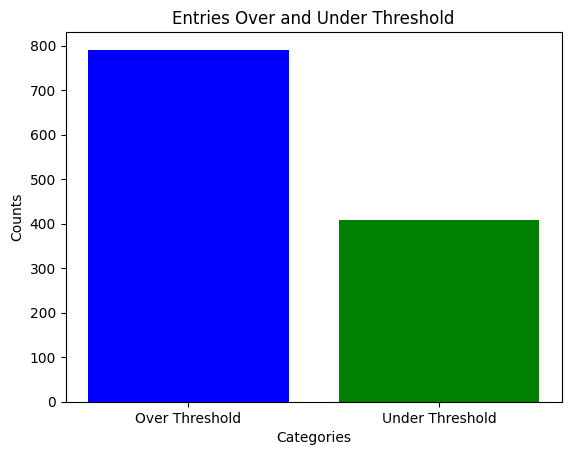

In [13]:
threshold = 800
over_thres  = (df["HIC15_max"] > threshold).sum()
under_thres = (df["HIC15_max"] <= threshold).sum()

print("Entries over the threshold:", over_thres)
print("Entries under the threshold:", under_thres)

# Data for the bar chart
categories = ['Over Threshold', 'Under Threshold']
counts = [over_thres, under_thres]

# Create the bar chart
plt.bar(categories, counts, color=['blue', 'green'])

# Add labels and title
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.title('Entries Over and Under Threshold')

# Show the plot
plt.show()

In [14]:
print(df.dtypes)

Unnamed: 0                                    int64
Path                                         object
CarProfile                                   object
Velocity                                      int64
Translation                                   int32
Rotation                                      int32
Position                                     object
HIC15_max                                   float64
HIC36_max                                   float64
Head_Z_Acceleration_abs_max                 float64
Head_X_Acceleration_abs_max                 float64
Head_Y_Acceleration_abs_max                 float64
BrIC_abs_max                                float64
Chest_Resultant_Acceleration_max            float64
Chest_Resultant_Acceleration_CLIP3ms_max    float64
dtype: object


### Preprocessing for classification

In [15]:
to_remove_features = ["Unnamed: 0", "Position", "Path",
                      "HIC36_max", 
                      "Head_Z_Acceleration_abs_max", "Head_X_Acceleration_abs_max", "Head_Y_Acceleration_abs_max",
                      "BrIC_abs_max", 
                      "Chest_Resultant_Acceleration_max", "Chest_Resultant_Acceleration_CLIP3ms_max"]
# Remove the unwanted columns
dfn = df.drop(columns=to_remove_features)

# Create a new target column for the classification
dfn["HIC15_over_800"] = (dfn["HIC15_max"] > 800).astype(int)
dfn = dfn.drop(columns=["HIC15_max"])

# Use pd.get_dummies for encoding
dfn = pd.get_dummies(dfn, columns=["CarProfile"], drop_first=False)
print(dfn.dtypes)
print(dfn.head())


Velocity          int64
Translation       int32
Rotation          int32
HIC15_over_800    int32
CarProfile_FCR     bool
CarProfile_MPV     bool
CarProfile_RDS     bool
CarProfile_SUV     bool
dtype: object
   Velocity  Translation  Rotation  HIC15_over_800  CarProfile_FCR  \
0       100         -200         0               0            True   
1       100         -200       120               1            True   
2       100         -200       150               0            True   
3       100         -200       180               0            True   
4       100         -200       210               0            True   

   CarProfile_MPV  CarProfile_RDS  CarProfile_SUV  
0           False           False           False  
1           False           False           False  
2           False           False           False  
3           False           False           False  
4           False           False           False  


In [16]:
# Split the data into features and target
X = dfn.drop(columns=["HIC15_over_800"])
y = dfn["HIC15_over_800"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Print value counts for the last four columns
columns_to_check = ['CarProfile_FCR', 'CarProfile_MPV', 'CarProfile_RDS', 'CarProfile_SUV']
for column in columns_to_check:
    print(f"Value counts for {column}:")
    print(X_test[column].value_counts())
    print()
# Step 6: Standardize/normalize the data if necessary
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Value counts for CarProfile_FCR:
CarProfile_FCR
False    178
True      62
Name: count, dtype: int64

Value counts for CarProfile_MPV:
CarProfile_MPV
False    180
True      60
Name: count, dtype: int64

Value counts for CarProfile_RDS:
CarProfile_RDS
False    180
True      60
Name: count, dtype: int64

Value counts for CarProfile_SUV:
CarProfile_SUV
False    182
True      58
Name: count, dtype: int64



### Binary classification

In [17]:

# Step 7: Build and train the neural network model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # For binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=10, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Plot the model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

c:\Users\geork\projects\AIThesis\src\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5625 - loss: 0.6532 - val_accuracy: 0.7000 - val_loss: 0.5326
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6499 - loss: 0.5858 - val_accuracy: 0.7000 - val_loss: 0.5222
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6986 - loss: 0.5581 - val_accuracy: 0.7083 - val_loss: 0.5276
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7043 - loss: 0.5450 - val_accuracy: 0.7083 - val_loss: 0.5332
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6807 - loss: 0.5604 - val_accuracy: 0.7000 - val_loss: 0.5259
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6473 - loss: 0.5652 - val_accuracy: 0.6917 - val_loss: 0.5285
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6919 - loss: 0.5544 - val_accuracy: 0.7375 - val_loss: 0.5245
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7064 - loss: 0.5441 - val_accuracy: 0.7042 - val_loss:

AttributeError: module 'pydot' has no attribute 'InvocationException'

## HIC15 regression

### Preprocessing

In [18]:
to_remove_features = ["Unnamed: 0", "Position", "Path",
                      "HIC36_max", 
                      "Head_Z_Acceleration_abs_max", "Head_X_Acceleration_abs_max", "Head_Y_Acceleration_abs_max",
                      "BrIC_abs_max", 
                      "Chest_Resultant_Acceleration_max", "Chest_Resultant_Acceleration_CLIP3ms_max"]
# Remove the unwanted columns
dfn_regr = df.drop(columns=to_remove_features)

# Use pd.get_dummies for encoding
dfn_regr = pd.get_dummies(dfn_regr, columns=["CarProfile"], drop_first=False)
print(dfn_regr.dtypes)
print(dfn_regr.head())


Velocity            int64
Translation         int32
Rotation            int32
HIC15_max         float64
CarProfile_FCR       bool
CarProfile_MPV       bool
CarProfile_RDS       bool
CarProfile_SUV       bool
dtype: object
   Velocity  Translation  Rotation  HIC15_max  CarProfile_FCR  CarProfile_MPV  \
0       100         -200         0     86.843            True           False   
1       100         -200       120   2361.697            True           False   
2       100         -200       150    573.455            True           False   
3       100         -200       180     84.702            True           False   
4       100         -200       210    592.965            True           False   

   CarProfile_RDS  CarProfile_SUV  
0           False           False  
1           False           False  
2           False           False  
3           False           False  
4           False           False  


In [19]:
# Split the data into features and target
X = dfn_regr.drop(columns=["HIC15_max"])
y = dfn_regr["HIC15_max"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Print value counts for the last four columns
columns_to_check = ['CarProfile_FCR', 'CarProfile_MPV', 'CarProfile_RDS', 'CarProfile_SUV']
for column in columns_to_check:
    print(f"Value counts for {column}:")
    print(X_test[column].value_counts())
    print()
# Step 6: Standardize/normalize the data if necessary
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Value counts for CarProfile_FCR:
CarProfile_FCR
False    178
True      62
Name: count, dtype: int64

Value counts for CarProfile_MPV:
CarProfile_MPV
False    180
True      60
Name: count, dtype: int64

Value counts for CarProfile_RDS:
CarProfile_RDS
False    180
True      60
Name: count, dtype: int64

Value counts for CarProfile_SUV:
CarProfile_SUV
False    182
True      58
Name: count, dtype: int64



### Regression attempt #1

In [20]:
# Build the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)  # Output layer for regression
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=32, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test, verbose=1)
print(f'Test MAE: {mae}')

# Make predictions
predictions = model.predict(X_test)

c:\Users\geork\projects\AIThesis\src\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 1119072512.0000 - mae: 10817.3740 - val_loss: 828146944.0000 - val_mae: 10706.4033
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 622481216.0000 - mae: 8983.8730 - val_loss: 827657536.0000 - val_mae: 10687.1455
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1185704960.0000 - mae: 11390.4746 - val_loss: 825647296.0000 - val_mae: 10623.5459
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 904444544.0000 - mae: 9663.3730 - val_loss: 819532864.0000 - val_mae: 10507.1875
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1027967040.0000 - mae: 10624.6689 - val_loss: 804305664.0000 - val_mae: 10294.0156
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1205596928.0000 - mae: 11132.5977 - val_loss: 777026240.0000 - val_mae: 10000.8770
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1003383232.0000 - mae: 10195.9785 - val_loss: 732974528.0000 - val_mae: 9630.4297
Epoch 

### Regression attempt #2

c:\Users\geork\projects\AIThesis\src\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 1105223936.0000 - mae: 10891.9023 - val_loss: 828157504.0000 - val_mae: 10706.9004
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1228572032.0000 - mae: 11769.5723 - val_loss: 827842112.0000 - val_mae: 10695.7334
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1131072384.0000 - mae: 10912.4248 - val_loss: 826746816.0000 - val_mae: 10662.7529
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1098980608.0000 - mae: 10878.4619 - val_loss: 823619904.0000 - val_mae: 10596.3525
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1058623936.0000 - mae: 11140.3076 - val_loss: 816637440.0000 - val_mae: 10492.4209
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1102270976.0000 - mae: 10617.7930 - val_loss: 803807040.0000 - val_mae: 10331.2354
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 897916352.0000 - mae: 9844.8125 - val_loss: 782095168.0000 - val_mae: 10085.9502
Epo

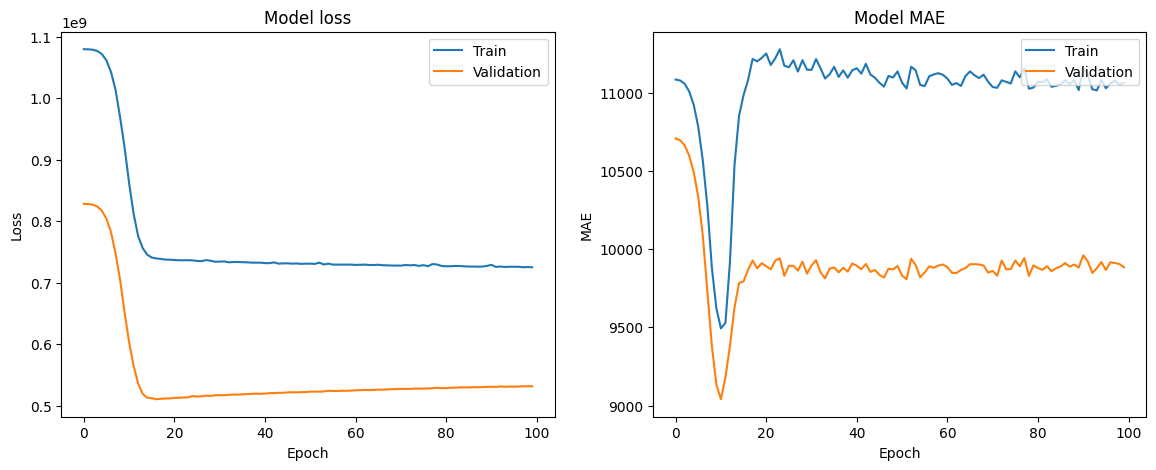

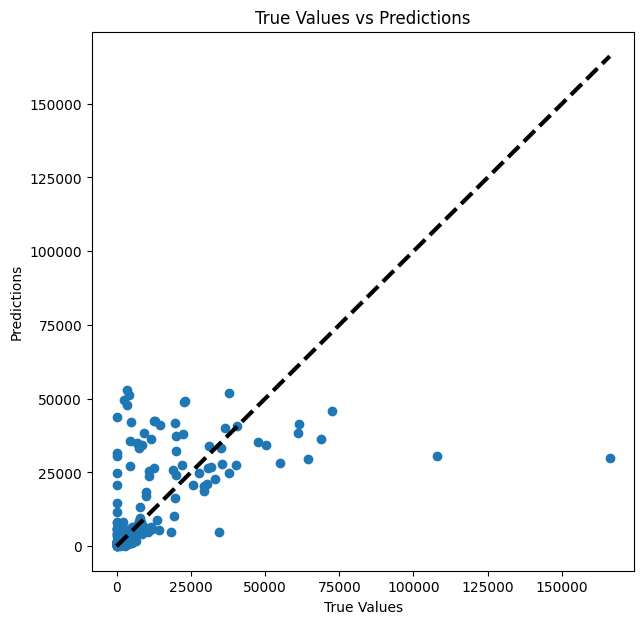

In [21]:
# Build the model
model = Sequential([
    Dense(128, activation='relu', kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Early stopping
#early_stop = EarlyStopping(monitor='val_loss', patience=10)

# Train the model
#history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=32, verbose=1, callbacks=[early_stop])
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=32, verbose=1)


# Evaluate the model
loss, mae = model.evaluate(X_test, y_test, verbose=1)
print(f'Test MSE: {loss}, Test MAE: {mae}')

# Make predictions
predictions = model.predict(X_test)

# Plot training & validation loss values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation MAE values
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()

# Scatter plot of predictions vs true values
plt.figure(figsize=(7, 7))
plt.scatter(y_test, predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs Predictions')
plt.show()

Our model's performance, as indicated by the high loss and MAE values, suggests that it may be underfitting or the dataset may have issues that need addressing. Here are several strategies to improve your model:

1. Data Preprocessing
- Feature Engineering: Create new features that might better represent the underlying data patterns.
- Scaling: Ensure all features are properly scaled.
- Outlier Removal: Remove or cap outliers in the dataset.
- Feature Selection: Ensure only the most relevant features are included.
2. Model Architecture
- Increase Complexity: Add more layers or neurons to your model.
- Activation Functions: Try different activation functions such as LeakyReLU or ELU.
- Regularization: Adjust regularization parameters.
3. Hyperparameter Tuning
- Use tools like GridSearchCV or RandomizedSearchCV to find the best hyperparameters.
4. Training Techniques
- Early Stopping: Use EarlyStopping with a more patient threshold.
- Learning Rate Scheduling: Adjust learning rates dynamically during training.
- Batch Normalization: Add batch normalization layers.
5. Visualizing and Debugging
- Residual Analysis: Analyze the residuals to understand model errors.
- Cross-Validation: Use cross-validation to ensure robustness.


### Regression attempt #3

Changes and Additions:
- Batch Normalization: Added after each Dense layer to help stabilize and speed up training.
- Dropout: Added to prevent overfitting.
- Early Stopping: More patient with a restore best weights option.
- Learning Rate Scheduling: Reduce learning rate if validation loss plateaus.


c:\Users\geork\projects\AIThesis\src\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 1202857600.0000 - mae: 11441.3730 - val_loss: 828232896.0000 - val_mae: 10710.5049 - learning_rate: 0.0010
Epoch 2/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1097225856.0000 - mae: 11526.4297 - val_loss: 828216512.0000 - val_mae: 10710.5127 - learning_rate: 0.0010
Epoch 3/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1299570816.0000 - mae: 12285.7793 - val_loss: 828193600.0000 - val_mae: 10710.4561 - learning_rate: 0.0010
Epoch 4/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1190470528.0000 - mae: 11590.6143 - val_loss: 828170048.0000 - val_mae: 10710.4336 - learning_rate: 0.0010
Epoch 5/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 984093184.0000 - mae: 10812.4355 - val_loss: 828147904.0000 - val_mae: 10710.4844 - learning_rate: 0.0010
Epoch 6/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1058915392.0000 - mae: 10781.5332 - val_loss: 828126016.0000 - val_mae: 10710.6025 - learning_rate: 0.0010

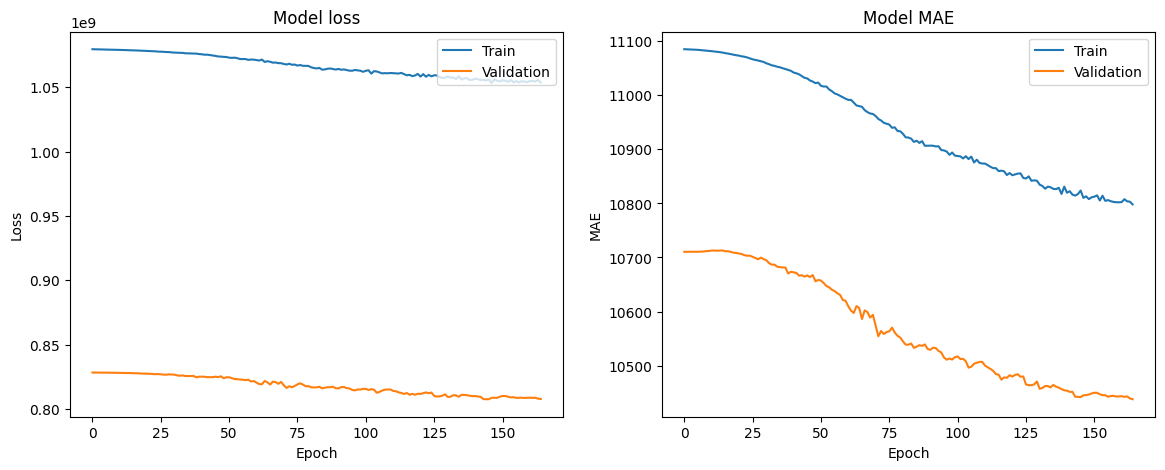

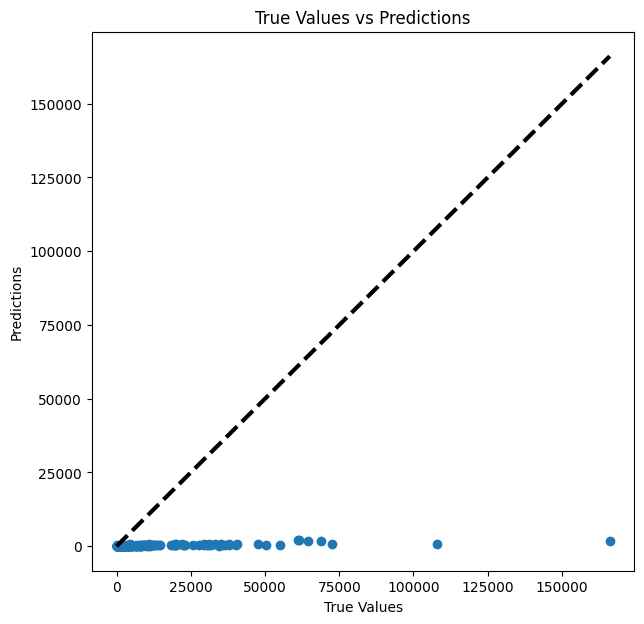

In [22]:
# Build the model
model = Sequential([
    Dense(128, activation='relu', kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)

# Train the model
history = model.fit(X_train, y_train, epochs=200, validation_split=0.2, batch_size=32, verbose=1, callbacks=[early_stop, reduce_lr])

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test, verbose=1)
print(f'Test MSE: {loss}, Test MAE: {mae}')

# Make predictions
predictions = model.predict(X_test)

# Plot training & validation loss values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation MAE values
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()

# Scatter plot of predictions vs true values
plt.figure(figsize=(7, 7))
plt.scatter(y_test, predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs Predictions')
plt.show()


## Transforming a Regression Problem into a Balanced Classification Task using Quantile Binning

Splitting the target variable HIC15_max into bins with an approximately equal number of items is a method called quantile binning. <br>
This ensures that each bin contains roughly the same number of samples, regardless of the actual value distribution.<br> This method can help address issues with skewed distributions and provide more balanced classes for classification tasks.

Here's how you can implement quantile binning in Python:

Use pd.qcut to create quantile bins.
Update the target variable and re-split the dataset.
Proceed with training a classification model.<br>
Here's a step-by-step guide and the corresponding code:

Step-by-Step Guide
Create Quantile Bins:

Use pd.qcut to split HIC15_max into a specified number of quantiles, ensuring each bin has an approximately equal number of samples.<br>
Modify the Target Variable:

Replace the continuous HIC15_max values with the new quantile bins.
Split the Data and Train a Classification Model:

Split the data into training and testing sets.
Standardize the features if necessary.
Train a classification model and evaluate its performance.

Notes:
Quantile Bins: The pd.qcut function automatically determines the bin edges so that each bin contains approximately the same number of observations. <br>Adjust number_of_bins according to your needs.
Labels: Assign meaningful labels to the bins, such as Q1, Q2, etc.
Model Selection and Evaluation: Different models might perform better on this transformed problem. Experiment with various classifiers and hyperparameters.
By using quantile binning, you ensure that your classes are balanced, which can lead to better performance and more reliable evaluation metrics for your classification models.

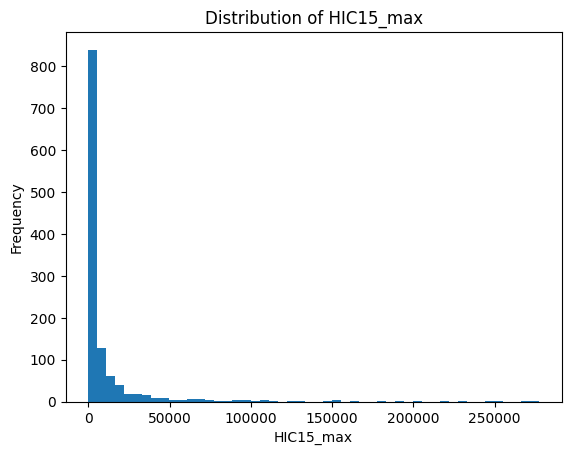

Ranges for each quantile bin:
Q1: 0.0 to 113.893625
Q2: 113.893625 to 444.45125
Q3: 444.45125 to 988.397375
Q4: 988.397375 to 1826.8964999999998
Q5: 1826.8964999999998 to 3490.965375
Q6: 3490.965375 to 7791.7429999999995
Q7: 7791.7429999999995 to 19452.69675
Q8: 19452.69675 to 277304.682
0       Q1
1       Q5
2       Q3
3       Q1
4       Q3
        ..
1195    Q3
1196    Q2
1197    Q2
1198    Q4
1199    Q5
Name: HIC15_max, Length: 1200, dtype: category
Categories (8, object): ['Q1' < 'Q2' < 'Q3' < 'Q4' < 'Q5' < 'Q6' < 'Q7' < 'Q8']
[[15  2  3  0  1  1  0  1]
 [ 2 18  3  0  2  1  0  0]
 [ 0  4 20  6  3  0  0  0]
 [ 0  1  2 13 12  4  0  0]
 [ 1  0  0  7 18  6  1  0]
 [ 0  0  0  3  1 13 10  2]
 [ 0  0  0  0  0  5 19  4]
 [ 0  0  0  0  0  1 11 24]]
              precision    recall  f1-score   support

          Q1       0.83      0.65      0.73        23
          Q2       0.72      0.69      0.71        26
          Q3       0.71      0.61      0.66        33
          Q4       0.45      

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Assuming dfn_regr is your DataFrame
# Check the distribution of the target variable
plt.hist(dfn_regr['HIC15_max'], bins=50)
plt.xlabel('HIC15_max')
plt.ylabel('Frequency')
plt.title('Distribution of HIC15_max')
plt.show()

# Create quantile bins
number_of_bins = 8  # You can adjust the number of bins as needed
y_binned, bin_edges = pd.qcut(dfn_regr['HIC15_max'], q=number_of_bins, labels=[f'Q{i+1}' for i in range(number_of_bins)], retbins=True)

# Print the ranges of the bins
print("Ranges for each quantile bin:")
for i in range(len(bin_edges) - 1):
    print(f"Q{i+1}: {bin_edges[i]} to {bin_edges[i+1]}")

# Replace the continuous target variable with the new binned variable
X = dfn_regr.drop(columns=["HIC15_max"])
y = y_binned
print(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize/normalize the data if necessary
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a classification model
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train, y_train)

# Predict and evaluate
y_pred = classifier.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


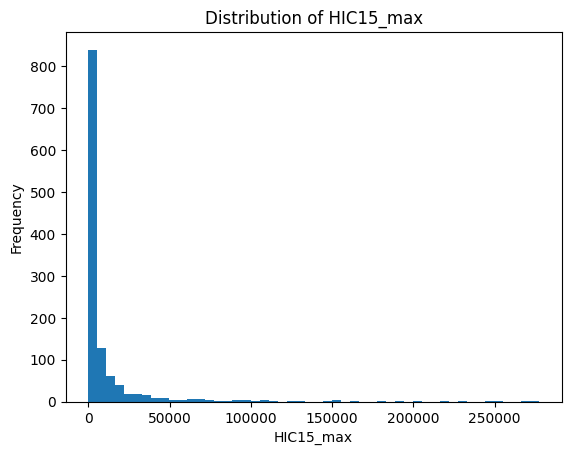

Ranges for each quantile bin:
Q1: 0.0 to 773.7126666666662
Q2: 773.7126666666662 to 4581.242999999994
Q3: 4581.242999999994 to 277304.682
0       Q1
1       Q2
2       Q1
3       Q1
4       Q1
        ..
1195    Q1
1196    Q1
1197    Q1
1198    Q2
1199    Q2
Name: HIC15_max, Length: 1200, dtype: category
Categories (3, object): ['Q1' < 'Q2' < 'Q3']


c:\Users\geork\projects\AIThesis\src\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.3172 - loss: 1.1920 - val_accuracy: 0.4625 - val_loss: 1.0439
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3850 - loss: 1.1104 - val_accuracy: 0.5458 - val_loss: 0.9895
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4454 - loss: 1.0365 - val_accuracy: 0.5667 - val_loss: 0.9430
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4847 - loss: 1.0047 - val_accuracy: 0.5875 - val_loss: 0.8935
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5100 - loss: 0.9878 - val_accuracy: 0.5708 - val_loss: 0.8541
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5124 - loss: 0.9357 - val_accuracy: 0.5625 - val_loss: 0.8205
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5754 - loss: 0.8957 - val_accuracy: 0.5708 - val_loss: 0.7990
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5329 - loss: 0.8828 - val_accuracy: 0.5833 - val_l

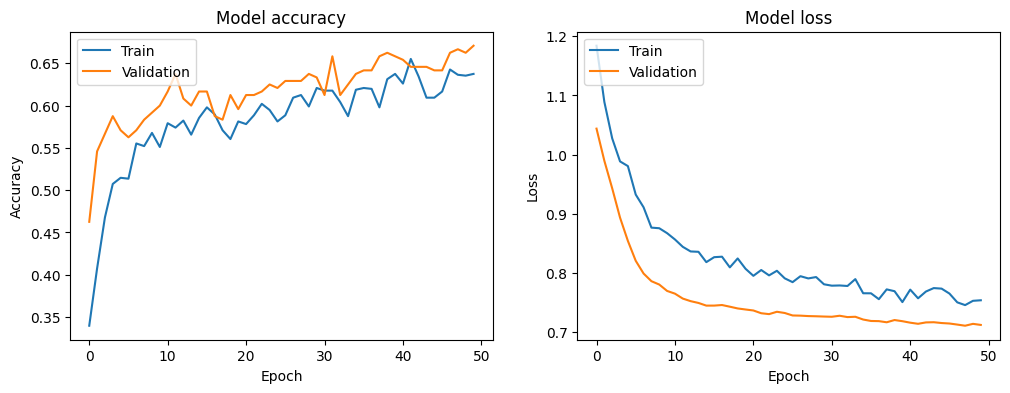

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Assuming dfn_regr is your DataFrame
# Check the distribution of the target variable
plt.hist(dfn_regr['HIC15_max'], bins=50)
plt.xlabel('HIC15_max')
plt.ylabel('Frequency')
plt.title('Distribution of HIC15_max')
plt.show()

# Create quantile bins
number_of_bins = 3  # You can adjust the number of bins as needed
y_binned, bin_edges = pd.qcut(dfn_regr['HIC15_max'], q=number_of_bins, labels=[f'Q{i+1}' for i in range(number_of_bins)], retbins=True)

# Print the ranges of the bins
print("Ranges for each quantile bin:")
for i in range(len(bin_edges) - 1):
    print(f"Q{i+1}: {bin_edges[i]} to {bin_edges[i+1]}")

# Replace the continuous target variable with the new binned variable
X = dfn_regr.drop(columns=["HIC15_max"])
y = y_binned
print(y)

# Convert categorical labels to numerical values
label_encoder = LabelEncoder()
y_numeric = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_numeric, test_size=0.2, random_state=42)

# Standardize/normalize the data if necessary
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert target variable to categorical
y_train_cat = to_categorical(y_train, num_classes=number_of_bins)
y_test_cat = to_categorical(y_test, num_classes=number_of_bins)

# Define the deep learning model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(number_of_bins, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_cat, epochs=50, batch_size=32, validation_data=(X_test, y_test_cat))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {accuracy:.4f}")

# Predict and evaluate
y_pred_cat = model.predict(X_test)
y_pred = np.argmax(y_pred_cat, axis=1)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


### Model with hyperparameter tuning

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Assuming dfn_regr is your DataFrame
# Check the distribution of the target variable
plt.hist(dfn_regr['HIC15_max'], bins=50)
plt.xlabel('HIC15_max')
plt.ylabel('Frequency')
plt.title('Distribution of HIC15_max')
plt.show()

# Create quantile bins
number_of_bins = 8  # You can adjust the number of bins as needed
y_binned, bin_edges = pd.qcut(dfn_regr['HIC15_max'], q=number_of_bins, labels=[f'Q{i+1}' for i in range(number_of_bins)], retbins=True)

# Print the ranges of the bins
print("Ranges for each quantile bin:")
for i in range(len(bin_edges) - 1):
    print(f"Q{i+1}: {bin_edges[i]} to {bin_edges[i+1]}")

# Replace the continuous target variable with the new binned variable
X = dfn_regr.drop(columns=["HIC15_max"])
y = y_binned

# Convert categorical labels to numerical values
label_encoder = LabelEncoder()
y_numeric = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_numeric, test_size=0.2, random_state=42)

# Standardize/normalize the data if necessary
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert target variable to categorical
y_train_cat = to_categorical(y_train, num_classes=number_of_bins)
y_test_cat = to_categorical(y_test, num_classes=number_of_bins)

# Define the deep learning model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(number_of_bins, activation='softmax'))

# Compile the model with a different learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_cat, epochs=200, batch_size=32, validation_data=(X_test, y_test_cat))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {accuracy:.4f}")

# Predict and evaluate
y_pred_cat = model.predict(X_test)
y_pred = np.argmax(y_pred_cat, axis=1)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


### Regularization with L2

In [ ]:
from tensorflow.keras.regularizers import l2

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Assuming dfn_regr is your DataFrame
# Check the distribution of the target variable
plt.hist(dfn_regr['HIC15_max'], bins=50)
plt.xlabel('HIC15_max')
plt.ylabel('Frequency')
plt.title('Distribution of HIC15_max')
plt.show()

# Create quantile bins
number_of_bins = 8  # You can adjust the number of bins as needed
y_binned, bin_edges = pd.qcut(dfn_regr['HIC15_max'], q=number_of_bins, labels=[f'Q{i+1}' for i in range(number_of_bins)], retbins=True)

# Print the ranges of the bins
print("Ranges for each quantile bin:")
for i in range(len(bin_edges) - 1):
    print(f"Q{i+1}: {bin_edges[i]} to {bin_edges[i+1]}")

# Replace the continuous target variable with the new binned variable
X = dfn_regr.drop(columns=["HIC15_max"])
y = y_binned

# Convert categorical labels to numerical values
label_encoder = LabelEncoder()
y_numeric = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_numeric, test_size=0.2, random_state=42)

# Standardize/normalize the data if necessary
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert target variable to categorical
y_train_cat = to_categorical(y_train, num_classes=number_of_bins)
y_test_cat = to_categorical(y_test, num_classes=number_of_bins)

# Define the deep learning model with L2 regularization
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(number_of_bins, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_cat, epochs=100, batch_size=32, validation_data=(X_test, y_test_cat))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {accuracy:.4f}")

# Predict and evaluate
y_pred_cat = model.predict(X_test)
y_pred = np.argmax(y_pred_cat, axis=1)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


Determining whether you need more data depends on several factors related to your current model's performance, the complexity of the problem, and the quality of the data. Here are some key considerations to help you decide if acquiring more data would be beneficial:

Indicators That You Might Need More Data
Validation Accuracy Plateau:

If your validation accuracy has plateaued and is not improving significantly despite different training techniques, this might indicate that the model has learned as much as it can from the current dataset and additional data could help.
Overfitting Signs:

If your model's training accuracy is much higher than the validation accuracy, this indicates overfitting. More data can help the model generalize better.
High Variance in Performance:

If there is high variability in model performance across different validation sets, this could indicate that your model is not seeing enough examples to learn robust patterns.
Complexity of the Problem:

Complex problems, especially those involving high-dimensional data or numerous classes, often benefit from larger datasets to capture the necessary variability and nuances.
Current Performance Analysis
Current Accuracy:

Your model's accuracy on the test set is 49%, which suggests it is not performing optimally. While this indicates there is room for improvement, it doesn't necessarily mean more data is the only solution.
Learning Curve Analysis:

Plotting learning curves (accuracy and loss for both training and validation sets over epochs) can help you understand if more data is needed. If the validation curve shows a significant gap from the training curve that doesn't narrow with more epochs, more data could help.
Strategies to Improve Without More Data
Before deciding to gather more data, consider these strategies to improve model performance:

Data Augmentation:

Generate synthetic data through augmentation techniques such as rotations, translations, and noise addition if your data is image-based. This can effectively increase the dataset size and variability without acquiring new data.
Regularization Techniques:

Use dropout, L2 regularization, or batch normalization to prevent overfitting and help the model generalize better.
Hyperparameter Tuning:

Experiment with different hyperparameters like learning rate, batch size, and network architecture to find the optimal settings for your model.
Feature Engineering:

Improve the quality of your features or extract new, more relevant features from your existing data.
Cross-Validation:

Use k-fold cross-validation to ensure your model's performance is robust and not due to random chance in train-test splits.
Conclusion
While more data can often help improve model performance, it is not always the first or most efficient solution. Analyze your current performance, employ advanced techniques to optimize the existing model, and use learning curves to make an informed decision. If after these improvements your model still shows signs of underperformance and overfitting, acquiring more data would likely be beneficial